In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
%matplotlib inline

In [2]:
ca_housing_dataset_url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
df = pd.read_csv(ca_housing_dataset_url)
df.head().T

,0,1,2,3,4
longitude,-122.23,-122.22,-122.24,-122.25,-122.25
latitude,37.88,37.86,37.85,37.85,37.85
housing_median_age,41.0,21.0,52.0,52.0,52.0
total_rooms,880.0,7099.0,1467.0,1274.0,1627.0
total_bedrooms,129.0,1106.0,190.0,235.0,280.0
population,322.0,2401.0,496.0,558.0,565.0
households,126.0,1138.0,177.0,219.0,259.0
median_income,8.3252,8.3014,7.2574,5.6431,3.8462
median_house_value,452600.0,358500.0,352100.0,341300.0,342200.0
ocean_proximity,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY,NEAR BAY


In [3]:
df = df.loc[df.ocean_proximity.isin(['<1H OCEAN', 'INLAND'])]
df.total_bedrooms = df.total_bedrooms.fillna(0)
df.median_house_value = np.log1p(df.median_house_value).values

In [4]:
X = df.drop('median_house_value', axis=1)
y = df.median_house_value

In [5]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [6]:
train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')
test_dict = X_test.to_dict(orient='records')
dv = DictVectorizer(sparse=True)
X_cat_train = dv.fit_transform(train_dict)
# you first need to fit the arrays before you have access to the feature names
feature_names = list(dv.get_feature_names_out())
X_cat_val = dv.transform(val_dict)
X_cat_test = dv.transform(test_dict)

### Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from 0.3 to 0.1.

Which `eta` leads to the best `RMSE` score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    feature_names = [name.replace("=<", "_") for name in feature_names]
    dtrain = xgb.DMatrix(X_cat_train, label=y_train, feature_names=feature_names)
    dval = xgb.DMatrix(X_cat_val, label=y_val, feature_names=feature_names)

In [8]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        
    df_results = pd.DataFrame(results, columns=['num_iter', 'rmse_train', 'rmse_val'])
    return df_results

In [9]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [10]:
%%capture output_eta_0_1

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [11]:
df_results_eta_0_1 = parse_xgb_output(output_eta_0_1)

In [12]:
%%capture output_eta_0_3

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [13]:
df_results_eta_0_3 = parse_xgb_output(output_eta_0_3)

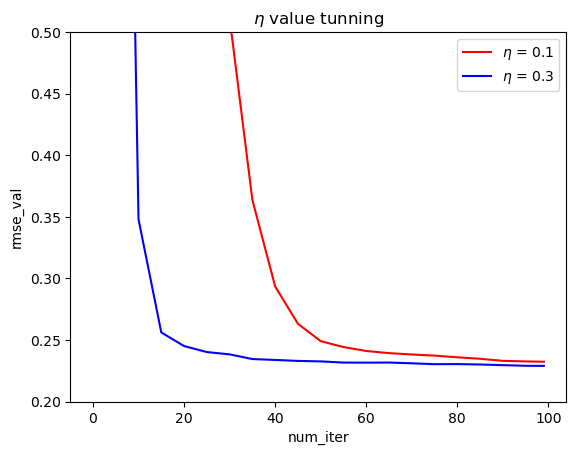

In [14]:
plt.plot(df_results_eta_0_1.num_iter, df_results_eta_0_1.rmse_val, color = 'red', label='$\eta$ = 0.1')
plt.plot(df_results_eta_0_3.num_iter, df_results_eta_0_3.rmse_val, color = 'blue', label='$\eta$ = 0.3')
plt.ylim([0.2, 0.5])
plt.title('$\eta$ value tunning')
plt.xlabel('num_iter')
plt.ylabel('rmse_val')
plt.legend()
plt.show()

In [15]:
df_results_eta_0_1.nsmallest(5, 'rmse_val')

,num_iter,rmse_train,rmse_val
20,99,0.17000,0.23234
19,95,0.17149,0.23258
18,90,0.17418,0.23307
17,85,0.17807,0.23475
16,80,0.18145,0.23594


In [16]:
df_results_eta_0_3.nsmallest(5, 'rmse_val')

,num_iter,rmse_train,rmse_val
20,99,0.11656,0.22897
19,95,0.11894,0.22906
18,90,0.12174,0.22957
17,85,0.12534,0.23010
15,75,0.13072,0.23036
